<a href="https://colab.research.google.com/github/sangnie/lyapunov_calc/blob/master/Calculate_lyapunov_exponents_pretrained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set-up

In [35]:
import os
import sys
import copy
import math
import pickle as pkl
import time
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from torch.autograd import Variable

In [2]:
!pip install pytorch_lightning
!pip install mod
!pip install blobfile
!pip install wandb
!pip install unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!git clone https://github.com/sangnie/lyapunov_calc.git
sys.path.insert(0,'/content/lyapunov_calc')

fatal: destination path 'lyapunov_calc' already exists and is not an empty directory.


In [40]:
from lyapunov_calc import config, lyapunov
from lyapunov_calc.models import RNNModel
from lyapunov_calc.training import train_model, load_checkpoint

from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

In [5]:
dropout = 0.1
uni_param = 0.08
batch_size = 128
max_epoch = 15
learning_rate = 0.002
sch = torch.optim.lr_scheduler.MultiStepLR
sch_params = {'milestones': range(10, 50), 'gamma': 0.95}
max_epoch = 15

In [6]:
!mkdir models
!mkdir LE_stats
!mkdir trials

mkdir: cannot create directory ‘models’: File exists
mkdir: cannot create directory ‘LE_stats’: File exists
mkdir: cannot create directory ‘trials’: File exists


In [7]:
device = torch.device('cpu')

In [8]:
data_config = config.DataConfig('/content/lyapunov_calc/CharRNN/WP/', input_seq_length=100, target_seq_length=1, train_frac=0.8, val_frac=0.1, test_frac=0.1, batch_size=batch_size)

Loading  /content/lyapunov_calc/CharRNN/WP/data.pkl ...
Loading  /content/lyapunov_calc/CharRNN/WP/vocab.pkl ...
None
Cutting off end of data so that it divides evenly
Data load done! Number of data batches in train: 200, val: 25, test: 24


In [9]:
model_type = 'rnn'
hidden_size = 512
model_config = config.ModelConfig(model_type, 1, hidden_size, data_config.input_size, data_config.input_size, dropout, 'uni', device, {'a': -uni_param, 'b':uni_param}, bias = False, id_init_param = 'b')
train_config = config.TrainConfig('lyapunov_calc/trained_models', batch_size, max_epoch, 'adam', learning_rate, {}, scheduler = sch, scheduler_params= sch_params, start_epoch = 0)
full_config = config.FullConfig(data_config, train_config, model_config)

# Helper fns

In [50]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
def plot_summary(val_losses, idcs, LEs):
    plt.rc('font', family = 'serif')
    plt.rc('xtick', labelsize = 'medium')
    plt.rc('ytick', labelsize = 'medium')
    fontsize = 12
    hidden_size = LEs.shape[1]
    fig= plt.figure(figsize = (8, 4))
    ax1 = fig.add_subplot(1, 2, 1)
    ax_max = fig.add_subplot(1, 2, 2)

    idcs = torch.LongTensor(idcs)
    val_lims = [torch.min(val_losses), torch.max(val_losses)]
    plt.rc('ytick', labelsize = 'small')
    plt.rc('xtick', labelsize = 'small')
    axin1 = ax1.inset_axes([0.15, 0.1, 0.38, 0.38])

    for i, idx in enumerate(idcs):
        axin1.plot(range(0,10), LEs[idx, :10], '-o', markersize = 2.5, linewidth = .5, label = idx.item())
        axin1.set_yticks([0, -.5])
    axin1.plot([0, 10], [0, 0], 'white', linewidth = .5)

    axin1.set_xlim([0,9])
    axin1.yaxis.set_minor_locator(MultipleLocator(.1))
    plt.rc('ytick', labelsize = 'medium')
    plt.rc('xtick', labelsize = 'medium')
    for idx in range(len(val_losses)):
        ax1.scatter(range(0,hidden_size), LEs[idx, :], s = .5, color = 'grey', alpha = .1)
    for i, idx in enumerate(idcs):
        ax1.scatter(range(0,hidden_size), LEs[idx, :], s = 2, label = idx.item())
    ax1.set_ylabel(r'$\lambda_i$', fontsize = fontsize)
    ax1.set_xlabel(r'$i$', fontsize = fontsize)
    ax1.set_ylim([-8, 0])
    ax1.set_xlim([0, hidden_size])


    x=  LEs[:, 0][idcs]
    # x = np.mean(LEs.numpy(), axis=1)[idcs]
    y = np.array(val_losses)[idcs]
    ax_max.scatter(LEs[:,0], val_losses, color = 'gray', alpha = 0.4)
    for i in range(x.shape[0]):
        ax_max.scatter(x[i], y[i], s = 50)

    ax_max.set_xlabel(r' Max LE, $\lambda_{max}$', fontsize  =12)
    ax_max.set_ylabel('Validation Loss', fontsize = 12)
    
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    

In [110]:
def calculate_LEs_and_losses(epoch=15, hidden_sizes=[64, 128, 512], base_dir='.'):
  for hidden_size in hidden_sizes:
      trials = pkl.load(open('lyapunov_calc/trials/{}_trials_{}.p'.format(full_config.model.model_type, hidden_size), 'rb'))
      full_config.model.rnn_atts['hidden_size'] = hidden_size
      lcon = config.LyapConfig(le_batch_size, le_seq_length, one_hot=True)
      data = lcon.get_input(full_config)

      LE_tensor = torch.zeros((15, hidden_size))
      LE_stds = torch.zeros((15, hidden_size))
      for i, trial in enumerate(trials):
          uni_param = trial['misc']['vals']['param'][0]
          full_config.model.init_params = {'a': -uni_param, 'b':uni_param}
          ckpt = load_checkpoint(full_config, epoch)
          model = ckpt[0].to(full_config.device)
          LE_stats = calc_lyap_helper(data, model, full_config, le_batch_size)
          LE_tensor[i, :], LE_stds[i, :] = LE_stats
      torch.save(LE_tensor, '{}/LE_stats/{}_{}_LEs.p'.format(base_dir, full_config.model.model_type, hidden_size))
      torch.save(LE_stds, '{}/LE_stats/{}_{}_LEerrors.p'.format(base_dir, full_config.model.model_type, hidden_size))

  for hidden_size in hidden_sizes:
      full_config.model.rnn_atts['hidden_size'] = hidden_size
      trials = pkl.load(open('lyapunov_calc/trials/{}_trials_{}.p'.format(full_config.model.model_type, hidden_size), 'rb'))
      final_tloss = torch.zeros((15))
      vlosses = torch.zeros((15))
      for i, trial in enumerate(trials):
          uni_param = trial['misc']['vals']['param'][0]
          full_config.model.init_params = {'a': -uni_param, 'b':uni_param}
          _, _, train_loss, val_loss = load_checkpoint(full_config, full_config.train.max_epoch)
          final_tloss[i] = train_loss[-1]
          vlosses[i] = val_loss
      torch.save(final_tloss, '{}/LE_stats/{}_{}_trainLoss.p'.format(base_dir, full_config.model.model_type, hidden_size))
      torch.save(vlosses, '{}/LE_stats/{}_{}_valLoss.p'.format(base_dir, full_config.model.model_type, hidden_size))

In [96]:
def calc_lyap_helper(le_input, model, fcon, batch_size):
		model.eval()
		model.lyapunov = True
		h = model.init_hidden(batch_size)
		i = torch.randint(low = 0, high = le_input.shape[0], size =  (1,)).item()
		LEs = calc_LEs(le_input[i], h, model = model, rec_layer=fcon.model.model_type)
		LE_mean, LE_std = lyapunov.LE_stats(LEs)
		model.lyapunov = False
		
		return (LE_mean, LE_std)

In [113]:
def calc_LEs(x_in, h0, model, num_LE=10000, rec_layer='rnn'):
	cuda = next(model.parameters()).is_cuda

	if cuda:
		device = torch.device('cuda')
	else:
		device = torch.device('cpu')
	bias = model.rnn_layer.bias

	x_in = Variable(x_in, requires_grad = False).to(device)
	h0 = Variable(h0, requires_grad = False).to(device)
 
	num_layers, batch_size, hidden_size = h0.shape
	_, feed_seq, input_size = x_in.shape
	L = num_layers * hidden_size
	num_LE = max(min(L, num_LE), 1)
	Q = torch.reshape(torch.eye(L), (1, L, L)).repeat(batch_size, 1, 1).to(device)
	Q = Q[:, :, :num_LE] 
	J = lyapunov.rnn_jac(model.rnn_layer.all_weights, h0, x_in[:, 0], bias=bias)
	Q, _ = lyapunov.oneStepVarQR(J, Q)


	ht = h0
	rvals = torch.ones(batch_size, feed_seq, num_LE).to(device)
	

	######
	t = 0
	Q, _ = torch.qr(Q, some=True)

	for xt in tqdm(x_in.transpose(0,1)):
		xt = torch.unsqueeze(xt, 1) # (batch_size, 1, input_size)
		ht = lyapunov.oneStep(xt, ht, model=model)
		
		J = lyapunov.rnn_jac(model.rnn_layer.all_weights, ht, xt, bias=bias)
		Q, r = lyapunov.oneStepVarQR(J, Q)
		rvals[:, t, :] = r
		t = t+1
	LEs = torch.sum(torch.log2(rvals.detach()), dim=1) / feed_seq
	######

	return LEs

# Train RNNs

In [ ]:
model_type = 'rnn'

In [ ]:
def objective(space):
    full_config = space['config']
    param = space['param']
    full_config.model.init_params = {'a': -param, 'b':param}
    model = RNNModel(full_config.model).to(model_config.device)
    optimizer = full_config.train.get_optimizer(model.parameters())
    train_loss, val_loss = train_model(full_config, model, optimizer, verbose = False, save_interval = 3)
    return {
        'loss': train_loss[-1],
        'status': STATUS_OK,
        'eval_time': time.time(),
        'val_loss': val_loss
    }

for hidden_size in [128]:
    print('Hidden Size: {}'.format(hidden_size))
    trials = Trials()

    model_config = config.ModelConfig(model_type, 1, hidden_size, data_config.input_size, data_config.input_size, dropout, 'uni', device, {'a': -uni_param, 'b':uni_param}, bias = False, id_init_param = 'b')
    train_config = config.TrainConfig('models', batch_size, max_epoch, 'adam', learning_rate, {}, scheduler = sch, scheduler_params= sch_params, start_epoch = 0)
    full_config = config.FullConfig(data_config, train_config, model_config)

    space = hp.choice('uni_param',[
        {
            'param': hp.quniform('param', .04, .24, .001),
            'config': full_config
        }    
    ])

    best = fmin(objective, 
                space=space,
                algo=tpe.suggest,
                trials=trials,
                max_evals=15)
    pkl.dump(trials, open('trials/{}_trials_{}.p'.format(full_config.model.model_type, hidden_size), 'wb'))


Hidden Size: 128
  0%|          | 0/15 [00:00<?, ?it/s, best loss: ?]

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


100%|██████████| 15/15 [04:01<00:00, 16.08s/it, best loss: 1.7954215383529664]


# Calculate Lyapunov Exponents

In [14]:
le_batch_size = 10
le_seq_length = 100

In [ ]:
calculate_LEs_and_losses(hidden_sizes=[512])

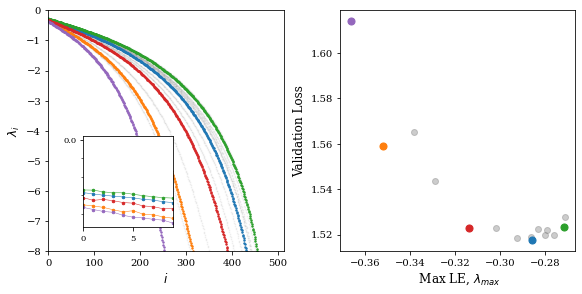

In [112]:
for hidden_size in [512]:
    full_config.model.rnn_atts['hidden_size'] = hidden_size
    full_config.model.model_type = model_type
    LEs = torch.load('LE_stats/{}_{}_LEs.p'.format(full_config.model.model_type, hidden_size))
    val_loss = torch.load('LE_stats/{}_{}_valLoss.p'.format(full_config.model.model_type, hidden_size))
    plot_summary(val_loss, [0,1,2,4,8], LEs)

PRETRAINED

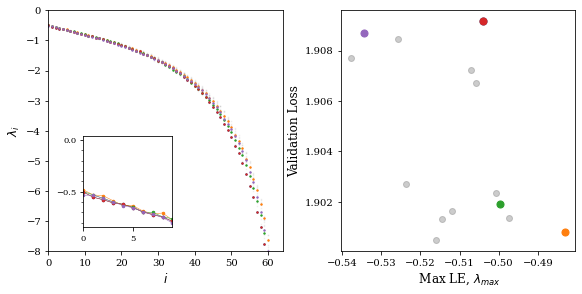

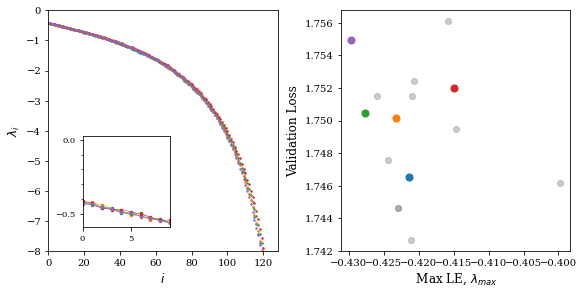

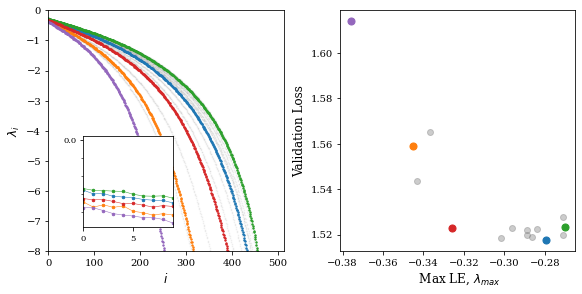

In [56]:
for hidden_size in [64, 128, 512]:
    full_config.model.rnn_atts['hidden_size'] = hidden_size
    full_config.model.model_type = model_type
    LEs = torch.load('lyapunov_calc/LE_stats/{}_{}_LEs.p'.format(full_config.model.model_type, hidden_size))
    train_loss = torch.load('lyapunov_calc/LE_stats/{}_{}_trainLoss.p'.format(full_config.model.model_type, hidden_size))
    val_loss = torch.load('lyapunov_calc/LE_stats/{}_{}_valLoss.p'.format(full_config.model.model_type, hidden_size))
    plot_summary(val_loss, [0,1,2,4,8], LEs)